<a href="https://colab.research.google.com/github/MiaKuntz/machine_learning_2/blob/main/ML4BI_E7_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for BI 2

## Deep Learning exercises for week 7

In this exercise, we will explore how far we can push our model performance on the cifar10 dataset. Your task now is to implement modern convnet architecture patterns like batchnorm, seperable depthwise convolutions and residual connections and examine how far this will boost performance.

**Load data and libraries**

In [ ]:
import tensorflow as tf # importing tensorflow library as tf
from tensorflow import keras # importing keras from tensorflow library
from tensorflow.keras.utils import to_categorical # importing to_categorical from tensorflow.keras.utils
from tensorflow.keras import datasets, layers, models # importing datasets, layers, models from tensorflow.keras
import matplotlib.pyplot as plt # importing matplotlib.pyplot as plt

# loading the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data() # loading CIFAR-10 dataset into train_images, train_labels, test_images, test_labels variables respectively 

# converting labels to one-hot encoding
train_labels = to_categorical(train_labels) # converting train_labels to one-hot encoding 
test_labels = to_categorical(test_labels) # converting test_labels to one-hot encoding

170498071/170498071 [==============================] - 6s 0us/step


**Build a mini Xception model**

In [ ]:
data_augmentation = keras.Sequential( # creating a sequential model for data augmentation
    [
        layers.RandomFlip("horizontal"), # flipping the image horizontally
        layers.RandomRotation(0.1), # rotating the image by 0.1
        layers.RandomZoom(0.2), # zooming the image by 0.2
    ]
)

In [ ]:
inputs = keras.Input(shape=(32, 32, 3)) # creating an input layer with shape (32, 32, 3)
x = data_augmentation(inputs) # applying data augmentation to the input layer

x = layers.Rescaling(1./255)(x) # rescaling the input layer by 1/255 to normalize the pixel values between 0 and 1 
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x) # applying convolutional layer with 32 filters and kernel size 5

for size in [32, 64, 128, 256]: # iterating over the sizes of the filters
    residual = x # assigning the value of x to residual

    x = layers.BatchNormalization()(x) # applying batch normalization to x
    x = layers.Activation("relu")(x) # applying relu activation function to x
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # applying separable convolutional layer with size, kernel size 3 and padding same

    x = layers.BatchNormalization()(x) # applying batch normalization to x
    x = layers.Activation("relu")(x) # applying relu activation function to x
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # applying separable convolutional layer with size, kernel size 3 and padding same

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # applying max pooling layer with pool size 3, strides 2 and padding same

    residual = layers.Conv2D( # applying convolutional layer with size, kernel size 1, strides 2, padding same and use bias false (residual connection layer that is used to add the original input back to the output of each Conv2D layer)
        size, 1, strides=2, padding="same", use_bias=False)(residual) 
    x = layers.add([x, residual]) # adding the output of the max pooling layer and the residual connection layer

x = layers.GlobalAveragePooling2D()(x) # applying global average pooling layer
x = layers.Dropout(0.5)(x) # applying dropout layer with rate 0.5
outputs = layers.Dense(10, activation="softmax")(x) # applying dense layer with 10 units and softmax activation function
model = keras.Model(inputs=inputs, outputs=outputs) # creating a model with inputs and outputs
model.summary() # printing the summary of the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           2400      ['rescaling[0][0]']           
                                                                                              

**Compile and train it**

In [ ]:
model.compile(optimizer='rmsprop', # compiling the model with optimizer rmsprop
              loss='categorical_crossentropy', # adding loss function categorical crossentropy
              metrics=['accuracy']) # setting the metrics to accuracy

callbacks = [ # creating a list of callbacks
    keras.callbacks.ModelCheckpoint( # creating a model checkpoint callback
        filepath="mini_xception.keras", # saving the model to mini_xception.keras
        save_best_only=True, # saving the best model
        monitor="val_loss") # monitoring the validation loss
]

history = model.fit(train_images, train_labels, # training the model with train_images and train_labels
                    epochs=100, # setting the number of epochs to 100
                    validation_split=0.2, # setting the validation split to 0.2
                    batch_size=256, # setting the batch size to 256
                    callbacks = callbacks) # adding the callbacks to the model

**Plot training and validation curves**

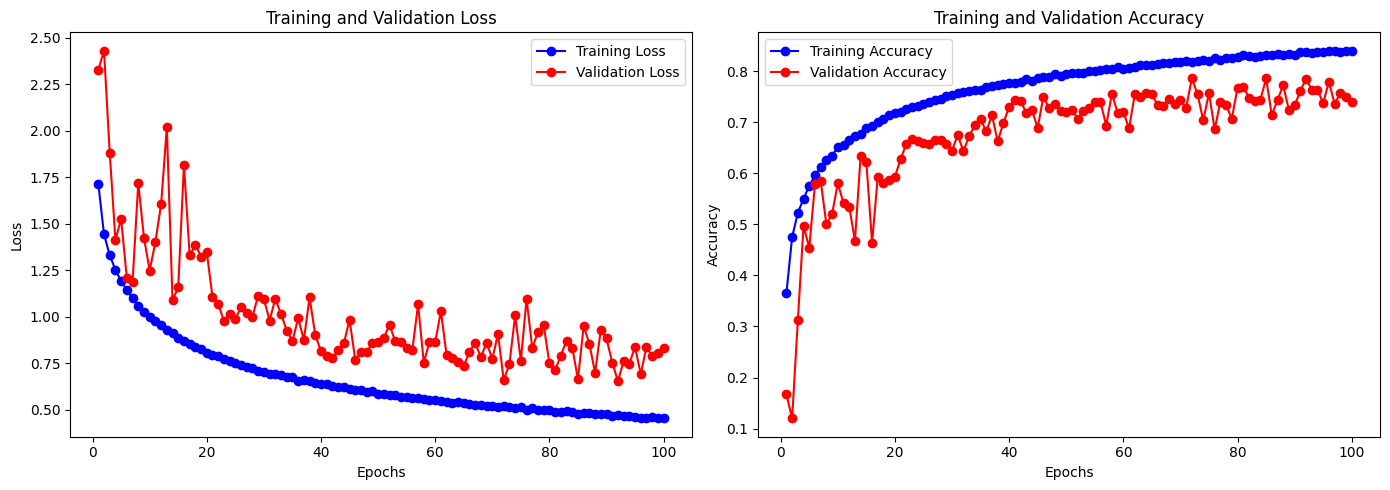

In [ ]:
# assuming 'history' is the return value from model.fit()
history_dict = history.history # extracting history dictionary from history

# extracting loss and accuracy history
train_loss = history_dict['loss'] # extracting training loss
val_loss = history_dict['val_loss'] # extracting validation loss
train_accuracy = history_dict['accuracy'] # extracting training accuracy
val_accuracy = history_dict['val_accuracy'] # extracting validation accuracy

epochs = range(1, len(train_loss) + 1) # setting the range of epochs

# plotting training and validation loss
plt.figure(figsize=(14, 5)) # setting the figure size

# training and validation loss plot
plt.subplot(1, 2, 1) # creating a subplot
plt.plot(epochs, train_loss, 'bo-', label='Training Loss') # plotting training loss
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss') # plotting validation loss
plt.title('Training and Validation Loss') # setting the title of the plot
plt.xlabel('Epochs') # setting the x-axis label
plt.ylabel('Loss') # setting the y-axis label
plt.legend() # adding legend to the plot

# training and validation accuracy plot
plt.subplot(1, 2, 2) # creating a subplot
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy') # plotting training accuracy
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy') # plotting validation accuracy
plt.title('Training and Validation Accuracy') # setting the title of the plot
plt.xlabel('Epochs') # setting the x-axis label
plt.ylabel('Accuracy') # setting the y-axis label
plt.legend() # adding legend to the plot

plt.tight_layout() # adjusting the subplot layout so that the plots do not overlap
plt.show() # displaying the plot
# the training and validation loss plot shows, that both the training and validation loss decrease over time, while the training and validation accuracy plot shows that both the training and validation accuracy increase over time
# this indicates that the model is learning and generalizing well to the data and is not overfitting 
# the model has a training accuracy of around 0.9 and a validation accuracy of around 0.7 

In [ ]:
import numpy as np # importing numpy library as np

def print_best_val_loss_and_accuracy(history): # defining a function to print the best validation loss and accuracy
    history_dict = history.history # extracting history dictionary from history

    # finding the index of the best validation loss
    best_val_loss_index = np.argmin(history_dict['val_loss']) # finding the index of the best validation loss

    # retrieving the best validation loss
    best_val_loss = history_dict['val_loss'][best_val_loss_index] # retrieving the best validation loss

    # retrieving the validation accuracy corresponding to the best validation loss
    best_val_accuracy = history_dict['val_accuracy'][best_val_loss_index] # retrieving the validation accuracy corresponding to the best validation loss

    print(f"Best Validation Loss: {best_val_loss}") # printing the best validation loss
    print(f"Validation Accuracy at Best Loss: {best_val_accuracy}") # printing the validation accuracy at best loss

In [ ]:
print_best_val_loss_and_accuracy(history) # calling the function to print the best validation loss and accuracy
# the best validation loss is 0.654616117477417
# the validation accuracy at the best loss is 0.785099983215332

Best Validation Loss: 0.654616117477417
Validation Accuracy at Best Loss: 0.785099983215332


**Evaluate best model on test set**

In [ ]:
best_model = keras.models.load_model("mini_xception.keras") # loading the best model

In [ ]:
test_loss, test_acc = best_model.evaluate(test_images, test_labels) # evaluating the best model on test images and test labels
print(f"Test accuracy: {test_acc}") # printing the test accuracy
# the test accuracy of the best model is 0.781000018119812

313/313 [==============================] - 2s 4ms/step - loss: 0.6764 - accuracy: 0.7810
Test accuracy: 0.781000018119812


**Discussion**

Test set accuracy of 78.1% with only 189,642 - our best model so far!

How good is this compared the current state-of-the-art on CIFAR-10? On [the benchmark overview](https://paperswithcode.com/sota/image-classification-on-cifar-10), this would place us at position 218. This might not seem impressive, but if you look at the parameters counts of the models in the visinity, you'll notice the our mini xception model is much, much smaller.

For instance, at position 206, we'll find a CCN Vision Transformer model with an accuracy of 83.36, but a parameter count of	906,075M! That's about 5 times more parameters than our 189,642 parameters.

Further, we are beating other more complicated models like the Hybrid Vision Nystromformer at place 221 with an accuracy of 75.26	and 623,706 parameters. That's 3%-points lower accuracy with around 3 times more parameters. Not bad!

Finally, we haven't even started tweaking our model yet. Based on the plots, we could lower the learning rate a bit a later epochs, to remove some noisy behavior. Adjusting dropout might also help a bit and the last dense layer. Of course, we could also build the model even deeper, but that would increase the parametrer count - hopefully while getting higher accuracy.